In [2]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from PIL import Image, ImageOps

2023-06-21 18:03:21.152850: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Datasets

In [6]:
image_data = []
tumor_directory = '/Users/admin-20218/Desktop/EPITA/Semester3/Deep Learning/Exam/Brain_Tumor/yes'
not_tumor_directory = '/Users/admin-20218/Desktop/EPITA/Semester3/Deep Learning/Exam/Brain_Tumor/no'

directories = [tumor_directory, not_tumor_directory]

for directory in directories:
    for filename in os.listdir(directory):
        if filename.lower().endswith((".jpg", ".jpeg", ".png")):
            img_gray_scale = ImageOps.grayscale(Image.open(os.path.join(directory, filename)))
            img_resized = img_gray_scale.resize((128, 128), Image.Resampling.LANCZOS)
            img_data = pd.DataFrame(np.array(img_resized).reshape(-1)).T
            img_data['status'] = 1 if directory == tumor_directory else 0
            image_data.append(img_data)

images = pd.concat(image_data)
images.reset_index(drop=True, inplace=True)

images

,0,1,2,3,4,5,6,7,8,9,...,16375,16376,16377,16378,16379,16380,16381,16382,16383,status
0,6,6,6,6,6,6,6,6,6,6,...,6,6,6,6,6,6,6,7,7,1
1,1,2,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,33,33,34,34,33,33,33,33,33,33,...,39,38,37,38,38,38,37,38,37,1
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
248,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,0
249,7,7,7,7,7,7,7,7,7,7,...,7,7,7,7,7,6,5,5,5,0
250,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
251,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


**<font color='blue'>Display some of the images of the dataset.**

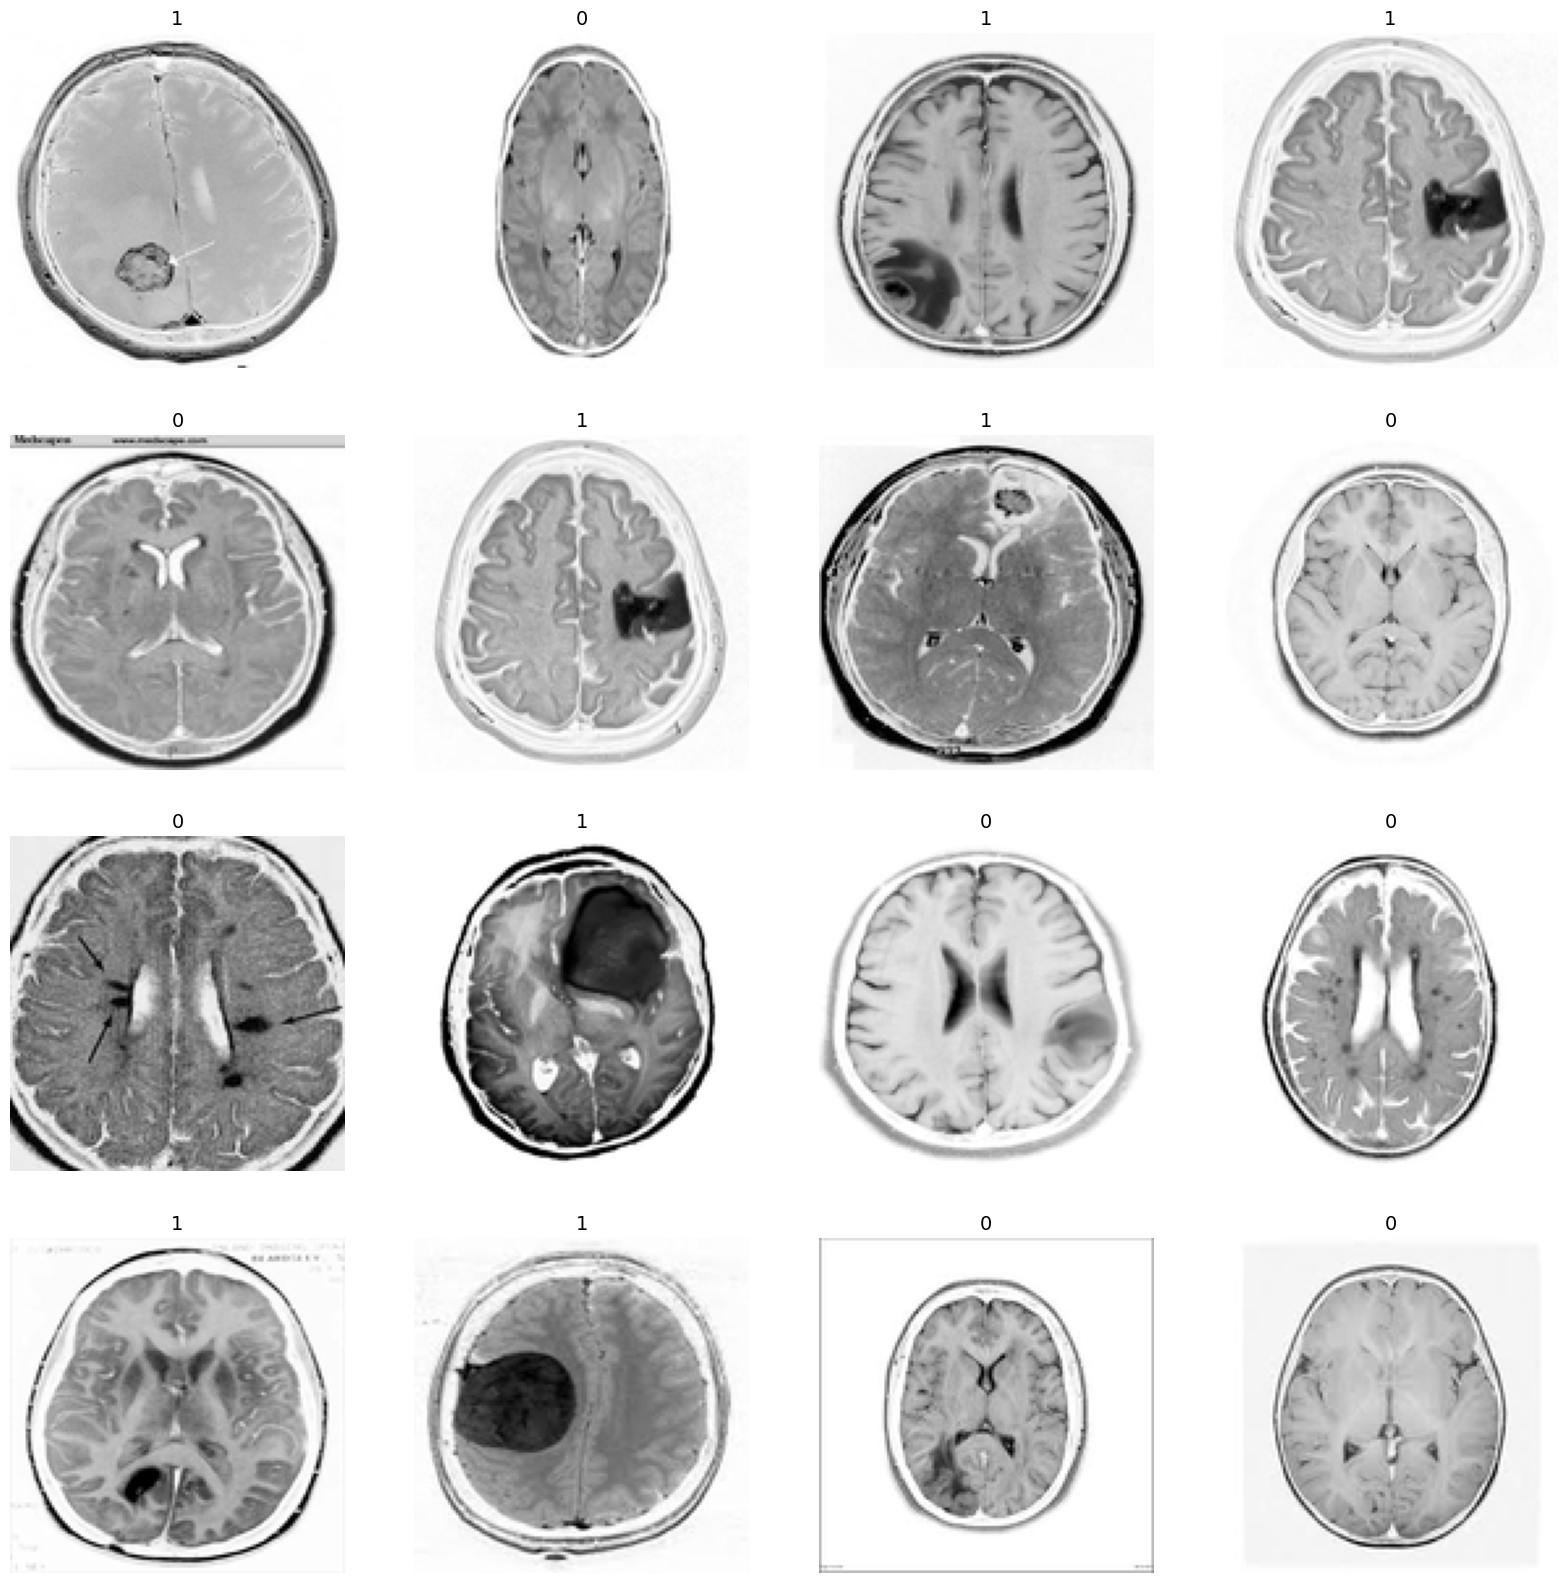

In [ ]:
fig, axs = plt.subplots(4,4, figsize=(20,20))

sample = images.sample(n=16)
imgs = sample.iloc[:,:-1].to_numpy().astype(np.int64)
labels = sample.iloc[:,-1].to_numpy()

for img, label, ax in zip(imgs, labels, axs.flatten()):
    ax.imshow(img.reshape(128,128), cmap='binary')
    ax.set_title(label, fontsize=14)
    ax.axis('off')

plt.show()

**<font color='blue'>Separate the features from the labels.**

In [11]:
X = images.copy()
y = X.pop('status')

**<font color='blue'>Create a training, a validation and a testing set.**

In [12]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,
                                                    stratify=y,
                                                    test_size=0.3,
                                                    random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_train,y_train,
                                                  stratify=y_train,
                                                  test_size=0.1/(1-0.3),
                                                  random_state=42)

**<font color='blue'>Preprocess the features by dividing the features by 255.**

In [13]:
X_train /= 255
X_val /= 255
X_test /= 255

**<font color='blue'>Encode the labels into numbers.**

In [15]:
from sklearn.preprocessing import LabelEncoder
lbl_enc = LabelEncoder()
y_train = lbl_enc.fit_transform(y_train)
y_val = lbl_enc.transform(y_val)
y_test = lbl_enc.transform(y_test)


**<font color='blue'>Reshape the training, validation and testing sets into a (instances, height,width, channel) format.**

In [17]:
X_train = X_train.to_numpy().reshape(-1,128,128,1)
X_val = X_val.to_numpy().reshape(-1,128,128,1)
X_test = X_test.to_numpy().reshape(-1,128,128,1)

# Create a model 

# Model 1

In [29]:
tf.keras.backend.clear_session()

model_conv = tf.keras.models.Sequential([tf.keras.layers.Input(shape = (128, 128, 1)),
                             tf.keras.layers.Conv2D(filters=32,
                                                   kernel_size=(3,3),
                                                   activation='relu'),
                             tf.keras.layers.MaxPooling2D(2),
                             tf.keras.layers.Flatten(),
                             tf.keras.layers.Dense(32, activation='relu'),
                             tf.keras.layers.Dense(10, activation = 'softmax')])

In [30]:
model_conv.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 32)       0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 127008)            0         
                                                                 
 dense (Dense)               (None, 32)                4064288   
                                                                 
 dense_1 (Dense)             (None, 10)                330       
                                                                 
Total params: 4,064,938
Trainable params: 4,064,938
Non-trainable params: 0
______________________________________________

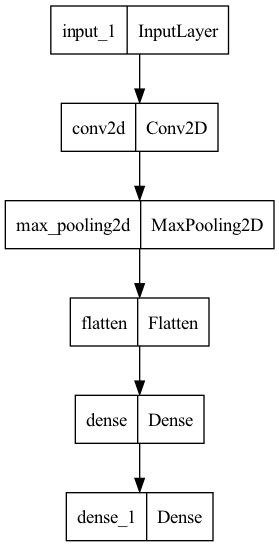

In [31]:
tf.keras.utils.plot_model(model_conv)

In [32]:
model_conv.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              metrics=["accuracy"])

**<font color='blue'> Training the model for 10 epochs with a batch size of 64.**

In [33]:
history = model_conv.fit(X_train, y_train,
                    epochs=10,
                    batch_size=64,
                    validation_data=(X_val, y_val))

Epoch 1/10
3/3 [==============================] - 5s 423ms/step - loss: 1.9394 - accuracy: 0.3510 - val_loss: 0.4239 - val_accuracy: 0.8077
Epoch 2/10
3/3 [==============================] - 1s 285ms/step - loss: 1.0028 - accuracy: 0.7219 - val_loss: 0.4635 - val_accuracy: 0.8077
Epoch 3/10
3/3 [==============================] - 1s 287ms/step - loss: 0.8714 - accuracy: 0.7417 - val_loss: 0.9795 - val_accuracy: 0.6923
Epoch 4/10
3/3 [==============================] - 1s 314ms/step - loss: 0.6101 - accuracy: 0.7483 - val_loss: 0.5540 - val_accuracy: 0.7308
Epoch 5/10
3/3 [==============================] - 2s 578ms/step - loss: 0.5641 - accuracy: 0.8278 - val_loss: 0.6662 - val_accuracy: 0.7692
Epoch 6/10
3/3 [==============================] - 1s 423ms/step - loss: 0.3304 - accuracy: 0.8874 - val_loss: 0.8592 - val_accuracy: 0.8077
Epoch 7/10
3/3 [==============================] - 1s 315ms/step - loss: 0.2273 - accuracy: 0.9338 - val_loss: 0.7659 - val_accuracy: 0.8077
Epoch 8/10
3/3 [====

**<font color='blue'> Display the learning curves.**

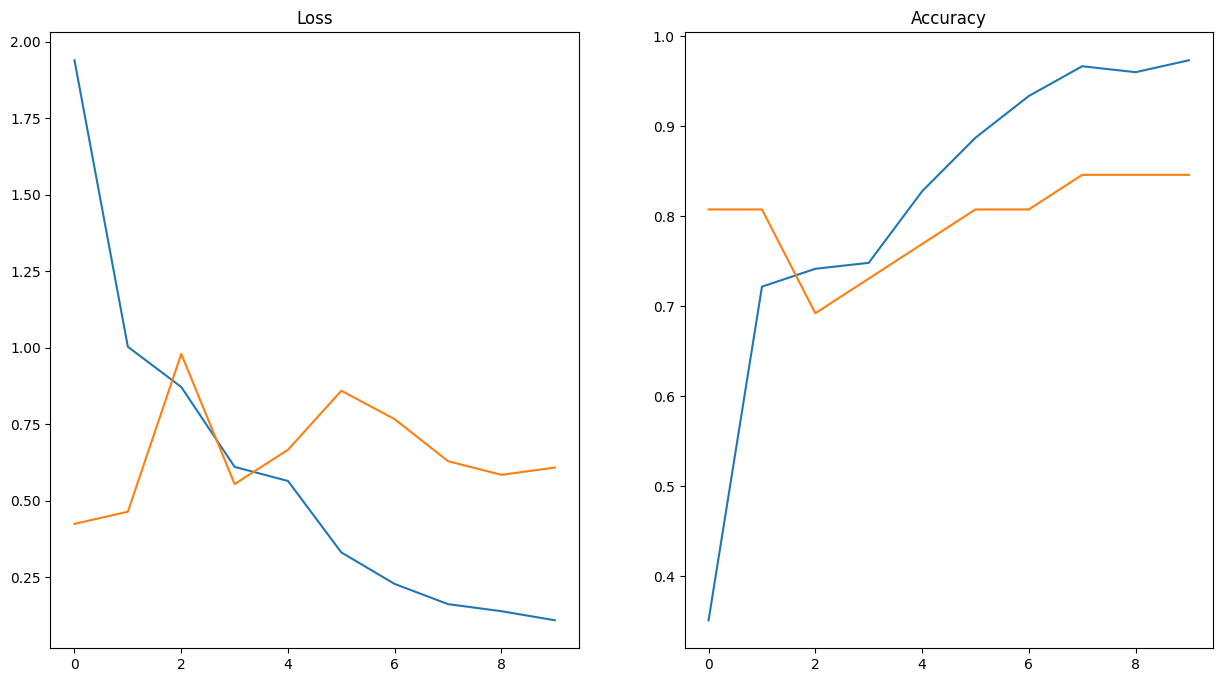

In [35]:
fig, axs = plt.subplots(1,2,figsize=(15,8))

axs[0].plot(history.history['loss'], label='loss')
axs[0].plot(history.history['val_loss'], label='val loss')
axs[0].set_title('Loss')
axs[1].plot(history.history['accuracy'], label='accuracy')
axs[1].plot(history.history['val_accuracy'], label='val accuracy')
axs[1].set_title('Accuracy')

plt.show()

**<font color='blue'>Evaluate the model on the test set.**

In [38]:
model_conv.evaluate(X_test, y_test)

3/3 [==============================] - 0s 74ms/step - loss: 0.5493 - accuracy: 0.8553


[0.5493305325508118, 0.8552631735801697]

In [39]:
y_pred=model_conv.predict(X_test)
y_pred=np.argmax(y_pred, axis=-1)

3/3 [==============================] - 0s 71ms/step


**<font color='blue'>display the confusion Matrix.**

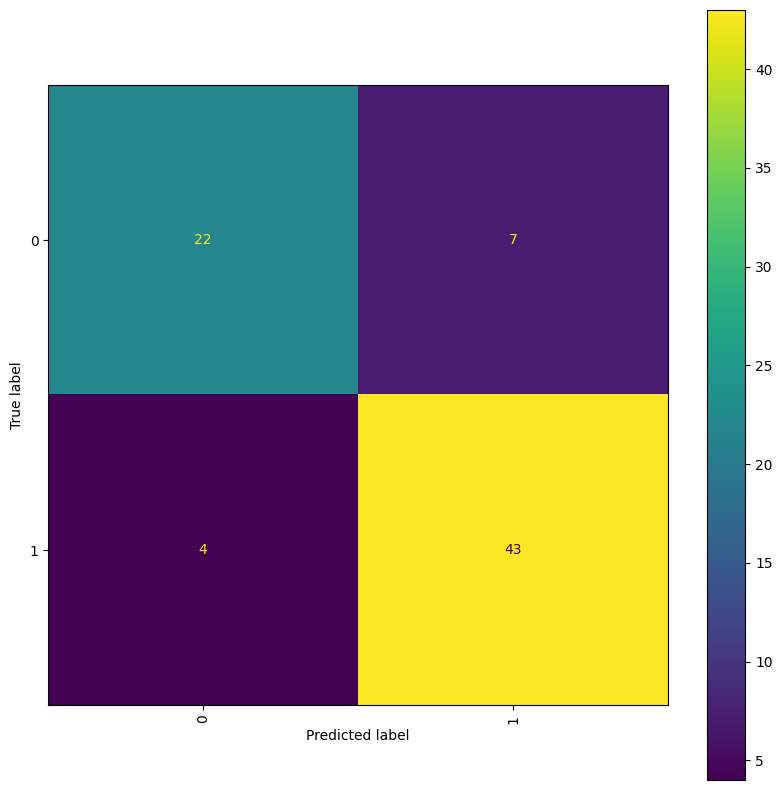

In [55]:
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred)

fig, ax = plt.subplots(figsize=(10,10))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, 
                                        ax=ax,
                                        display_labels=lbl_enc.classes_,
                                        xticks_rotation='vertical')
plt.show()

# Model 2

In [49]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define the CNN
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(128, 128, 1)),
    MaxPooling2D(2,2),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.001), metrics=['accuracy'])


In [50]:
# Train the model
history = model.fit(X_train, y_train,
                    epochs=10,
                    batch_size=64,
                    validation_data=(X_val, y_val))

Epoch 1/10
3/3 [==============================] - 6s 1s/step - loss: 2.8754 - accuracy: 0.5828 - val_loss: 0.9682 - val_accuracy: 0.3846
Epoch 2/10
3/3 [==============================] - 3s 1s/step - loss: 0.9434 - accuracy: 0.4106 - val_loss: 0.5312 - val_accuracy: 0.7692
Epoch 3/10
3/3 [==============================] - 3s 1s/step - loss: 0.5102 - accuracy: 0.7881 - val_loss: 0.4437 - val_accuracy: 0.7692
Epoch 4/10
3/3 [==============================] - 6s 2s/step - loss: 0.5128 - accuracy: 0.7748 - val_loss: 0.4083 - val_accuracy: 0.8077
Epoch 5/10
3/3 [==============================] - 4s 1s/step - loss: 0.4846 - accuracy: 0.7815 - val_loss: 0.3613 - val_accuracy: 0.8077
Epoch 6/10
3/3 [==============================] - 4s 1s/step - loss: 0.4302 - accuracy: 0.7815 - val_loss: 0.3285 - val_accuracy: 0.8846
Epoch 7/10
3/3 [==============================] - 5s 1s/step - loss: 0.4013 - accuracy: 0.8146 - val_loss: 0.3330 - val_accuracy: 0.8462
Epoch 8/10
3/3 [=========================

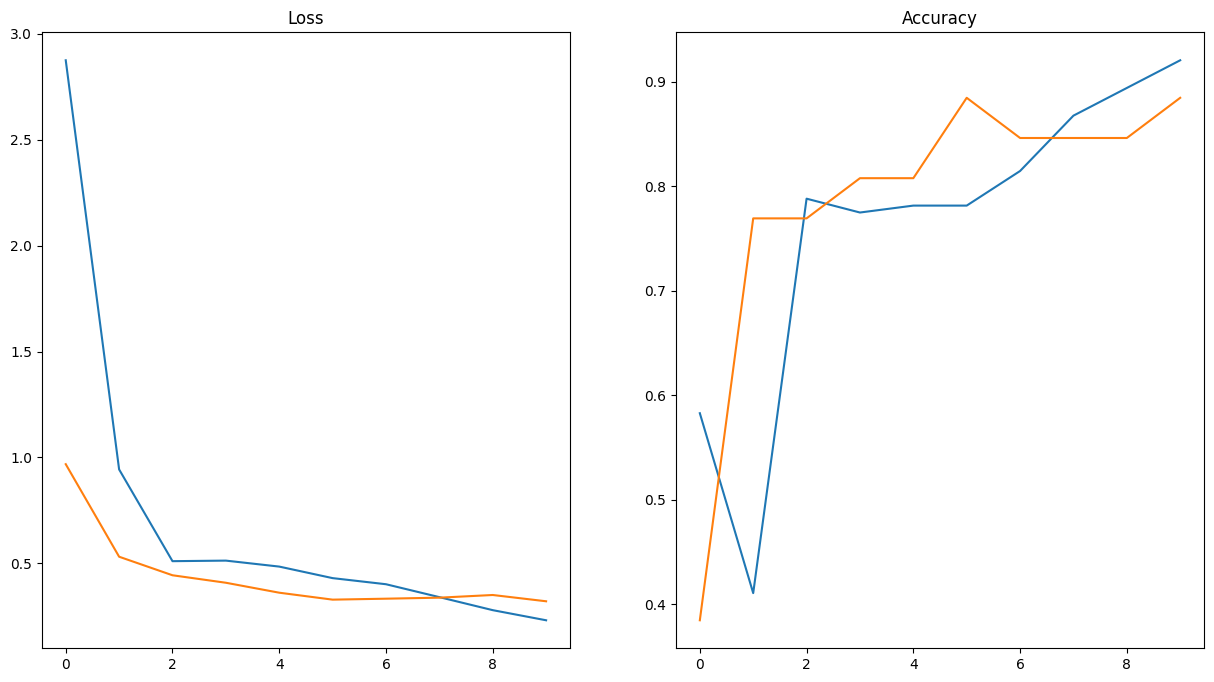

In [51]:
fig, axs = plt.subplots(1,2,figsize=(15,8))

axs[0].plot(history.history['loss'], label='loss')
axs[0].plot(history.history['val_loss'], label='val loss')
axs[0].set_title('Loss')
axs[1].plot(history.history['accuracy'], label='accuracy')
axs[1].plot(history.history['val_accuracy'], label='val accuracy')
axs[1].set_title('Accuracy')

plt.show()

In [57]:
model.evaluate(X_test, y_test)

3/3 [==============================] - 0s 113ms/step - loss: 0.5183 - accuracy: 0.7763


[0.5183292031288147, 0.7763158082962036]

In [60]:
y_pred=model.predict(X_test)
y_pred=np.argmax(y_pred, axis=-1)

3/3 [==============================] - 0s 108ms/step


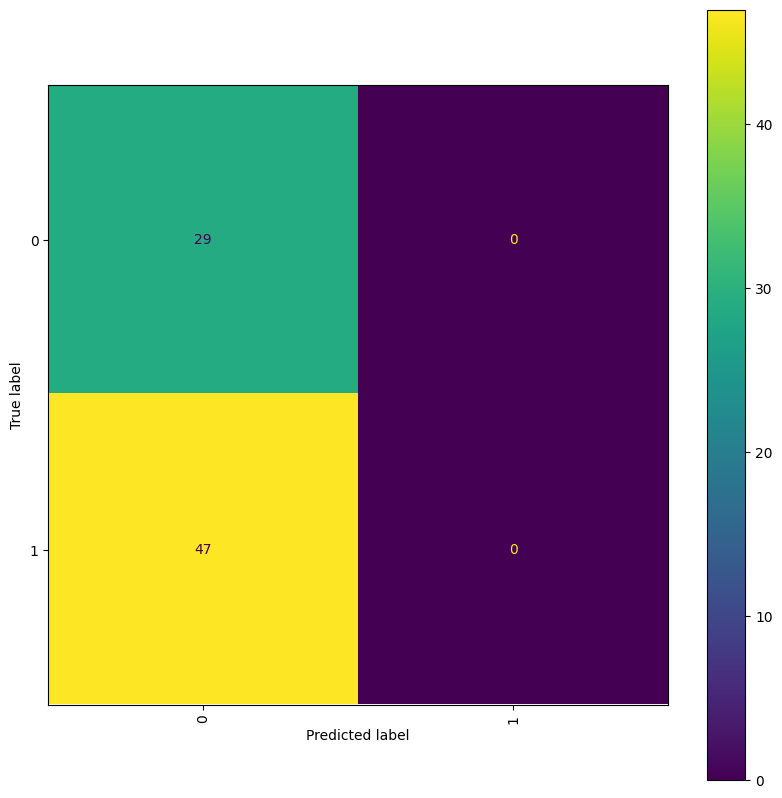

In [61]:
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred)

fig, ax = plt.subplots(figsize=(10,10))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, 
                                        ax=ax,
                                        display_labels=lbl_enc.classes_,
                                        xticks_rotation='vertical')
plt.show()

In [62]:
#  BY comparing the two models, we notice that the first one is more accurate than the second one